In [1]:
# This is the import cell
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
first = True
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 10)

# Here are my rc parameters for matplotlib
mpl.rc('font', serif='Helvetica Neue') 
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['figure.figsize'] = 3.2, 2.8
mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 1.5

In [2]:
# Get the current path
if first:
    parent = os.getcwd()
os.chdir(parent)

# Grab file names from data folder
data = os.listdir('state_density')
data = os.listdir('weakEps_densities')
try:
    data.remove('.DS_Store')
except:
    print(".DS_Store not in directory")

# Grab the MCS data
mcs_data = os.listdir('mcs_data')
mcs_data = os.listdir('weakEps')
try:
    data.remove('.DS_Store')
except:
    print(".DS_Store not in directory")
    
print(data)
print(mcs_data)

.DS_Store not in directory
.DS_Store not in directory
['phase_density_pa400_pb0_xa0_phi45.txt', 'phase_density_pa500_pb0_xa0_phi50.txt', 'phase_density_pa200_pb0_xa0_phi55.txt', 'phase_density_pa500_pb0_xa0_phi45.txt', 'phase_density_pa400_pb0_xa0_phi50.txt', 'phase_density_pa300_pb0_xa0_phi55.txt', 'phase_density_pa100_pb0_xa0_phi55.txt', 'phase_density_pa100_pb0_xa0_phi45.txt', 'phase_density_pa100_pb0_xa0_phi50.txt', 'phase_density_pa300_pb0_xa0_phi45.txt', 'phase_density_pa200_pb0_xa0_phi50.txt', 'phase_density_pa500_pb0_xa0_phi55.txt', 'phase_density_pa200_pb0_xa0_phi45.txt', 'phase_density_pa300_pb0_xa0_phi50.txt', 'phase_density_pa400_pb0_xa0_phi55.txt', 'phase_density_pa400_pb0_xa0_phi70.txt', 'phase_density_pa500_pb0_xa0_phi65.txt', 'phase_density_pa200_pb0_xa0_phi60.txt', 'phase_density_pa500_pb0_xa0_phi70.txt', 'phase_density_pa400_pb0_xa0_phi65.txt', 'phase_density_pa300_pb0_xa0_phi60.txt', 'phase_density_pa100_pb0_xa0_phi60.txt', 'phase_density_pa100_pb0_xa0_phi70.txt', 'p

In [3]:
# Some functions to get the relevant data from the filenames
def checkFile(fname, string):
    for i in xrange(len(fname)):
        if fname[i] == string[0]:
#             print"{} matches {}".format(fname[i], string[0])
            for j in xrange(1, len(string)):
                if fname[i + j] == string[j]:
#                     print"{} matches {}".format(fname[i+j], string[j])
                    if j == (len(string) - 1):
#                         print"Final match!"
                        return True
                else:
                    break
    return False
    
def txtValue(fname, string):
    out = ""
    index = 0
    for i in xrange(len(fname)):
        if fname[i] == string[0]:
            for j in xrange(1, len(string)):
                if fname[i + j] == string[j]:
                    if j == (len(string) - 1):
                        # Last index of search string
                        index = i + j
                else:
                    break
                        
    # First index of value
    index += 1
    mybool = True
    while mybool:
        if fname[index].isdigit():
            out = out + fname[index]
            index += 1
        elif fname[index] == ".":    
            if fname[index+1].isdigit():
                out = out + fname[index]
                index += 1
            else:
                mybool = False
        else:
            mybool = False
    return float(out)

# Sorting functions
def multiSort(arr1, arr2, arr3):
    """Sort an array the slow (but certain) way, returns original indices in sorted order"""
    # Doing this for PeR, PeS, xS in this case
    cpy1 = np.copy(arr1)
    cpy2 = np.copy(arr2)
    cpy3 = np.copy(arr3)
    ind = np.arange(0, len(arr1))
    for i in xrange(len(cpy1)):
        for j in xrange(len(cpy1)):
            # Sort by first variable
            if cpy1[i] > cpy1[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            # If first variable is equal, resort to second variable
            elif cpy1[i] == cpy1[j] and cpy2[i] > cpy2[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            elif cpy1[i] == cpy1[j] and cpy2[i] == cpy2[j] and cpy3[i] > cpy3[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]      
    return ind

def indSort(arr1, arr2):
    """Take sorted index array, use to sort array"""
    # arr1 is array to sort
    # arr2 is index array
    cpy = np.copy(arr1)
    for i in xrange(len(arr1)):
        arr1[i] = cpy[arr2[i]]

In [4]:
# Grab parameters, sort them
def computePeNet(PeS, PeF, xF):
    # Make sure particle fraction is in appropriate range
    if xF > 1.:
        xF /= 100.
    # Make sure slow species is actually slower
    if PeS > PeF:
        PeS, PeF = PeF, PeS
        xF = 1. - xF
    peNet = ((1. - xF) * PeS) + (xF * PeF)
    if PeF != 0:
        peRNet = (((1. - xF)*(np.sqrt(PeS/PeF))) + xF) * peNet
    else:
        peRNet = 0.
    return peNet, peRNet

peList = []
paList = []
pbList = []
xaList = []
epList = []
phiList = []
peNetList = []
peRNetList = []
for i in xrange(len(data)):
    if checkFile(data[i], "pe"):
        peList.append(txtValue(data[i], "pe"))
    else:
        peList.append(0)
    
    if checkFile(data[i], "pa"):
        paList.append(txtValue(data[i], "pa"))
    else:
        paList.append(0)
        
    if checkFile(data[i], "pb"):
        pbList.append(txtValue(data[i], "pb"))
    else:
        pbList.append(0)
        
    if checkFile(data[i], "xa"):
        xaList.append(txtValue(data[i], "xa"))
    else:
        xaList.append(100.)
        
    if checkFile(data[i], "ep"):
        epList.append(txtValue(data[i], "ep"))
    else:
        epList.append(1.)
        
    if checkFile(data[i], "phi"):
        phiList.append(txtValue(data[i], "phi"))
    else:
        phiList.append(60.)
    
    peNet, peRNet = computePeNet(paList[-1], pbList[-1], 100. - xaList[-1])
    peNetList.append(peNet)
    peRNetList.append(peRNet)

# Take a look at your lists
# print(peList)
# print(paList) 
# print(pbList) 
# print(xaList) 
# print(epList) 
# print(phiList)        

# Sort the arrays
if len(paList) > 1:
    # Sort them!
    print("Sorting... ")
    indArr = multiSort(paList, phiList, epList)
    indSort(data, indArr)
    indSort(peList, indArr)
    indSort(paList, indArr)
    indSort(pbList, indArr)
    indSort(xaList, indArr)
    indSort(epList, indArr)
    indSort(phiList, indArr)
    indSort(peNetList, indArr)
    indSort(peRNetList, indArr)

# Print the sorted array
print("Sorted textfiles:")
for i in data:
    print(i)
    
# Now that the data is sorted, read it into a dataframe
all_data = []
# os.chdir('state_density')
os.chdir('weakEps_densities')
for i in xrange(len(data)):
    df = pd.read_csv(data[i], sep='\s+', header=0)
    all_data.append(df)
os.chdir(parent)

# This is how you access the data at different levels
display(all_data[0])
# print(all_data[0]['Timestep'])
# print(all_data[0]['Timestep'][0])

Sorting... 
Sorted textfiles:
phase_density_pa100_pb0_xa0_phi45.txt
phase_density_pa100_pb0_xa0_phi50.txt
phase_density_pa100_pb0_xa0_phi55.txt
phase_density_pa100_pb0_xa0_phi60.txt
phase_density_pa100_pb0_xa0_phi65.txt
phase_density_pa100_pb0_xa0_phi70.txt
phase_density_pa200_pb0_xa0_phi45.txt
phase_density_pa200_pb0_xa0_phi50.txt
phase_density_pa200_pb0_xa0_phi55.txt
phase_density_pa200_pb0_xa0_phi60.txt
phase_density_pa200_pb0_xa0_phi65.txt
phase_density_pa200_pb0_xa0_phi70.txt
phase_density_pa300_pb0_xa0_phi45.txt
phase_density_pa300_pb0_xa0_phi50.txt
phase_density_pa300_pb0_xa0_phi55.txt
phase_density_pa300_pb0_xa0_phi60.txt
phase_density_pa300_pb0_xa0_phi65.txt
phase_density_pa300_pb0_xa0_phi70.txt
phase_density_pa400_pb0_xa0_phi45.txt
phase_density_pa400_pb0_xa0_phi50.txt
phase_density_pa400_pb0_xa0_phi55.txt
phase_density_pa400_pb0_xa0_phi60.txt
phase_density_pa400_pb0_xa0_phi65.txt
phase_density_pa400_pb0_xa0_phi70.txt
phase_density_pa500_pb0_xa0_phi45.txt
phase_density_pa500_

,Timestep,Gas-r=1.0,Liq-r=1.0,Gas-r=1.5,Liq-r=1.5,Gas-r=2.0,Liq-r=2.0,Gas-r=2.5,Liq-r=2.5,Gas-r=3.0,Liq-r=3.0,Gas-r=3.5,Liq-r=3.5,Gas-r=4.0,Liq-r=4.0,Gas-r=4.5,Liq-r=4.5,Gas-r=5.0,Liq-r=5.0
0,100.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.465,0.395,0.455
1,200.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.395,0.455
2,300.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.420,0.455
3,400.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
4,500.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.485,0.39,0.465,0.395,0.455,0.420,0.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,700.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.420,0.455
7,800.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.430,0.455
8,900.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.485,0.39,0.465,0.395,0.455,0.430,0.455
9,1000.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.420,0.455


In [5]:
# Do the same for the MCS data
mcs_peList = []
mcs_paList = []
mcs_pbList = []
mcs_xaList = []
mcs_epList = []
mcs_phiList = []
mcs_peNetList = []
mcs_peRNetList = []
for i in xrange(len(mcs_data)):
    if checkFile(mcs_data[i], "pe"):
        mcs_peList.append(txtValue(mcs_data[i], "pe"))
    else:
        mcs_peList.append(0)
    
    if checkFile(mcs_data[i], "pa"):
        mcs_paList.append(txtValue(mcs_data[i], "pa"))
    else:
        mcs_paList.append(0)
        
    if checkFile(mcs_data[i], "pb"):
        mcs_pbList.append(txtValue(mcs_data[i], "pb"))
    else:
        mcs_pbList.append(0)
        
    if checkFile(mcs_data[i], "xa"):
        mcs_xaList.append(txtValue(mcs_data[i], "xa"))
    else:
        mcs_xaList.append(100.)
        
    if checkFile(mcs_data[i], "ep"):
        mcs_epList.append(txtValue(mcs_data[i], "ep"))
    else:
        mcs_epList.append(1.)
        
    if checkFile(mcs_data[i], "phi"):
        mcs_phiList.append(txtValue(mcs_data[i], "phi"))
    else:
        mcs_phiList.append(60.)
    
    peNet, peRNet = computePeNet(mcs_paList[-1], mcs_pbList[-1], 100. - mcs_xaList[-1])
    mcs_peNetList.append(peNet)
    mcs_peRNetList.append(peRNet)

# Take a look at your lists
# print(peList)
# print(paList) 
# print(pbList) 
# print(xaList) 
# print(epList) 
# print(phiList)        

# Sort the arrays
if len(mcs_paList) > 1:
    # Sort them!
    print("Sorting... ")
    indArr = multiSort(mcs_paList, mcs_phiList, mcs_epList)
    indSort(mcs_data, indArr)
    indSort(mcs_peList, indArr)
    indSort(mcs_paList, indArr)
    indSort(mcs_pbList, indArr)
    indSort(mcs_xaList, indArr)
    indSort(mcs_epList, indArr)
    indSort(mcs_phiList, indArr)
    indSort(mcs_peNetList, indArr)
    indSort(mcs_peRNetList, indArr)

# Print the sorted array
print("Sorted textfiles:")
for i in mcs_data:
    print(i)
    
# Now that the data is sorted, read it into a dataframe
mcs = []
os.chdir('mcs_data')
for i in xrange(len(mcs_data)):
    df = pd.read_csv(mcs_data[i], sep='\s+', header=0)
    mcs.append(df)
os.chdir(parent)

# This is how you access the data at different levels
display(mcs[0])
# print(all_data[0]['Timestep'])
# print(all_data[0]['Timestep'][0])

Sorting... 
Sorted textfiles:
MCS_pa100_pb0_xa0_phi45.txt
MCS_pa100_pb0_xa0_phi50.txt
MCS_pa100_pb0_xa0_phi55.txt
MCS_pa100_pb0_xa0_phi60.txt
MCS_pa100_pb0_xa0_phi65.txt
MCS_pa100_pb0_xa0_phi70.txt
MCS_pa200_pb0_xa0_phi45.txt
MCS_pa200_pb0_xa0_phi50.txt
MCS_pa200_pb0_xa0_phi55.txt
MCS_pa200_pb0_xa0_phi60.txt
MCS_pa200_pb0_xa0_phi65.txt
MCS_pa200_pb0_xa0_phi70.txt
MCS_pa300_pb0_xa0_phi45.txt
MCS_pa300_pb0_xa0_phi50.txt
MCS_pa300_pb0_xa0_phi55.txt
MCS_pa300_pb0_xa0_phi60.txt
MCS_pa300_pb0_xa0_phi65.txt
MCS_pa300_pb0_xa0_phi70.txt
MCS_pa400_pb0_xa0_phi45.txt
MCS_pa400_pb0_xa0_phi50.txt
MCS_pa400_pb0_xa0_phi55.txt
MCS_pa400_pb0_xa0_phi60.txt
MCS_pa400_pb0_xa0_phi65.txt
MCS_pa400_pb0_xa0_phi70.txt
MCS_pa500_pb0_xa0_phi45.txt
MCS_pa500_pb0_xa0_phi50.txt
MCS_pa500_pb0_xa0_phi55.txt
MCS_pa500_pb0_xa0_phi60.txt
MCS_pa500_pb0_xa0_phi65.txt
MCS_pa500_pb0_xa0_phi70.txt


,Timestep,c1,p1,c5,p5,c10,p10,c50,p50,c100,p100,c500,p500,c1000,p1000,c5000,p5000,c10000,p10000,c50000,p50000
0,0.0,94226,100000,5,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.1,37932,100000,3819,53030,1677,39267,130,9236,16,1898,0,0,0,0,0,0,0,0,0,0
2,0.2,36866,100000,3582,53818,1582,40954,169,13486,33,4443,0,0,0,0,0,0,0,0,0,0
3,0.3,36639,100000,3413,53797,1505,41680,188,16384,52,7110,0,0,0,0,0,0,0,0,0,0
4,0.4,36672,100000,3361,53927,1524,42220,187,16422,48,6913,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,99.5,31331,100000,1300,60091,257,53549,2,50027,1,49975,1,49975,1,49975,1,49975,1,49975,0,0
996,99.6,31521,100000,1297,59930,253,53468,1,50029,1,50029,1,50029,1,50029,1,50029,1,50029,1,50029
997,99.7,31330,100000,1258,59836,257,53621,1,50098,1,50098,1,50098,1,50098,1,50098,1,50098,1,50098
998,99.8,31474,100000,1274,59986,252,53681,1,50142,1,50142,1,50142,1,50142,1,50142,1,50142,1,50142


In [6]:
# Function to get conversion from timesteps to Brownian time
def computeTauPerTstep(epsilon, mindt=0.00001):
    if epsilon == 1.:
        mindt = 0.000001
    kBT = 1.0
    tstepPerTau = int(epsilon / (kBT * mindt))
    return 1. / tstepPerTau

# Grab the parameters from each file, store in a dataframe
headers = ['pe', 'peA', 'peB', 'xA', 'peR', 'peNet', 'peRNet', 'eps', 'phi', 'tauPer_dt']
params = pd.DataFrame(columns=headers)
for i in xrange(len(all_data)):
    pe = int(peList[i])
    pa = int(paList[i])
    pb = int(pbList[i])
    xa = float(xaList[i])
    if xa != 0 and xa != 100:
        if pa > pb:
            peR = float(pb) / float(pa)
        else:
            peR = float(pa) / float(pb)
    else:
        peR = 1.
    peNet = float(peNetList[i])
    peRNet = float(peRNetList[i])
    ep = int(epList[i])
    phi = float(phiList[i])
    if ep == 1:
        tauPerdt = computeTauPerTstep(ep, 0.000001)
    else:
        tauPerdt = computeTauPerTstep(ep)
    df = pd.DataFrame([[pe, pa, pb, xa, peR, peNet, peRNet, ep, phi, tauPerdt]], columns=headers)
    params = params.append(df, ignore_index = True)
display(params)

,pe,peA,peB,xA,peR,peNet,peRNet,eps,phi,tauPer_dt
0,0,100,0,0.0,1.0,0.0,0.0,1,45.0,0.000001
1,0,100,0,0.0,1.0,0.0,0.0,1,50.0,0.000001
2,0,100,0,0.0,1.0,0.0,0.0,1,55.0,0.000001
3,0,100,0,0.0,1.0,0.0,0.0,1,60.0,0.000001
4,0,100,0,0.0,1.0,0.0,0.0,1,65.0,0.000001
...,...,...,...,...,...,...,...,...,...,...
25,0,500,0,0.0,1.0,0.0,0.0,1,50.0,0.000001
26,0,500,0,0.0,1.0,0.0,0.0,1,55.0,0.000001
27,0,500,0,0.0,1.0,0.0,0.0,1,60.0,0.000001
28,0,500,0,0.0,1.0,0.0,0.0,1,65.0,0.000001


In [7]:
# Let's add columns to the time-resolved simulation data
for i in xrange(len(all_data)):
    # Ger rid of NaN in favor of 0
    all_data[i].fillna(0, inplace=True)

# display(all_data[0][0])
headers=list(all_data[0])
display(all_data[0])
print(all_data[0][headers[1]][0])
print(all_data[0][headers[2]][0])

,Timestep,Gas-r=1.0,Liq-r=1.0,Gas-r=1.5,Liq-r=1.5,Gas-r=2.0,Liq-r=2.0,Gas-r=2.5,Liq-r=2.5,Gas-r=3.0,Liq-r=3.0,Gas-r=3.5,Liq-r=3.5,Gas-r=4.0,Liq-r=4.0,Gas-r=4.5,Liq-r=4.5,Gas-r=5.0,Liq-r=5.0
0,100.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.465,0.395,0.455
1,200.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.395,0.455
2,300.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.420,0.455
3,400.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
4,500.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.485,0.39,0.465,0.395,0.455,0.420,0.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,700.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.420,0.455
7,800.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.430,0.455
8,900.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.485,0.39,0.465,0.395,0.455,0.430,0.455
9,1000.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.420,0.455


0.25
0.5


In [8]:
%%capture
# Plot each column vs time for all files
for z in list(all_data[0]):
    for i in xrange(len(all_data)):
        plt.plot(all_data[i]['Timestep'], all_data[i][z], c=plt.cm.jet(params['peNet'][i] / max(params['peNet'])), label=(params['pe'][i]))
    plt.xlabel(r'Time $(\tau_{r})$')
    plt.ylabel(z)
    plt.title(z)
#     plt.legend()
    plt.show()

Totals


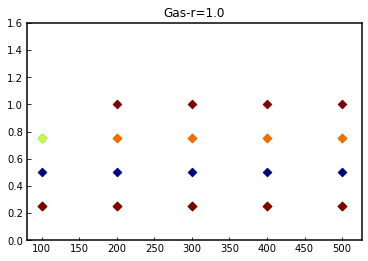

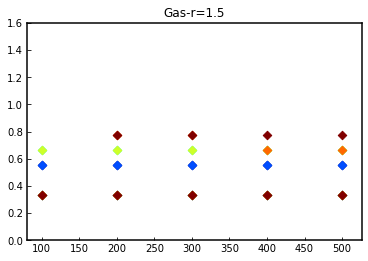

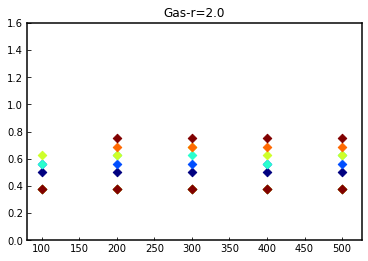

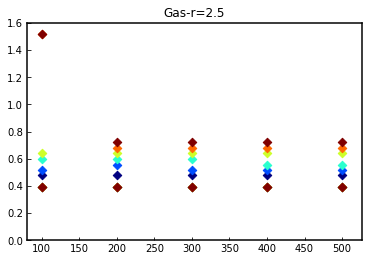

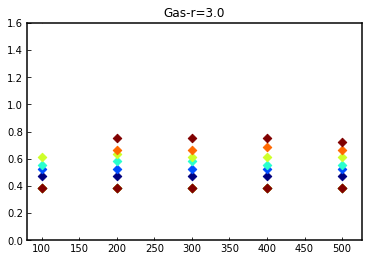

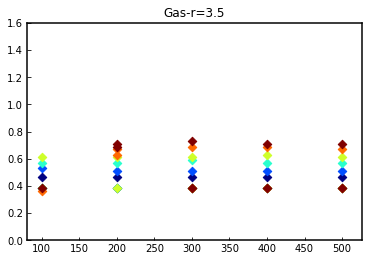

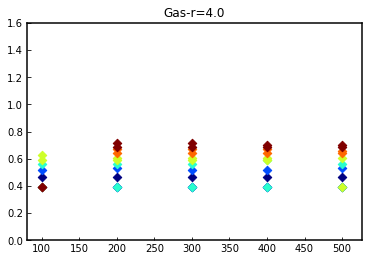

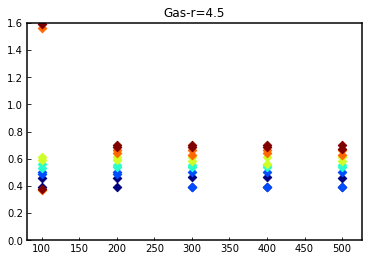

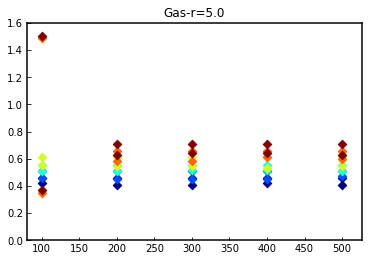

In [9]:
# Let's try and plot phiG and phiC vs peNet
print("Totals")

headers=list(all_data[0])
# for j in range(1, len(headers) - 1, 2):
#     # We want columns, phi= 45, 50, 55, 60, 65, 70
#     for i in xrange(len(all_data)):
#         plt.scatter(params['peA'][i], all_data[i][headers[j]][0], c=plt.cm.jet(params['peA'][i]/500.), marker='D')
#         plt.scatter(params['peA'][i], all_data[i][headers[j+1]][0], c=plt.cm.jet(params['peA'][i]/500.), marker='D')
#     plt.title(headers[j])
#     plt.ylim(0, 1.2)
#     plt.show()
    
for j in range(1, len(headers) - 1, 2):
    # We want columns, phi= 45, 50, 55, 60, 65, 70
    for i in xrange(len(all_data)):
        plt.scatter(params['peA'][i], all_data[i][headers[j]].iloc[-1], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
        plt.scatter(params['peA'][i], all_data[i][headers[j+1]].iloc[-1], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
    plt.title(headers[j])
    plt.ylim(0, 1.6)
    plt.show()

[45.0, 50.0, 55.0, 60.0, 65.0, 70.0]


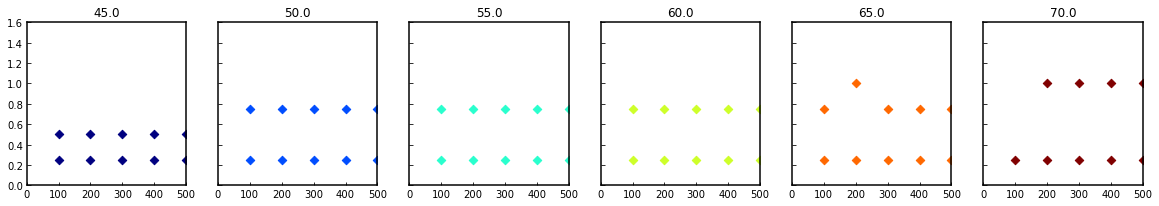

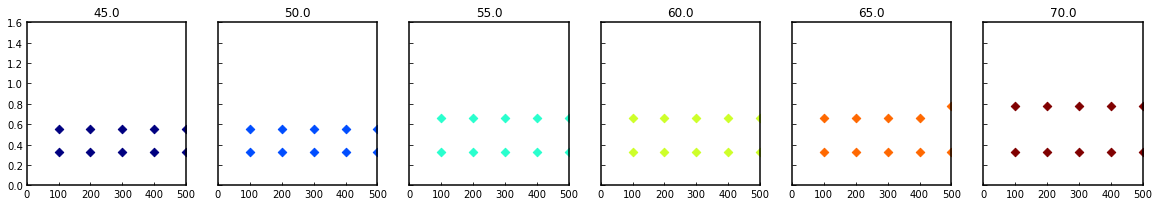

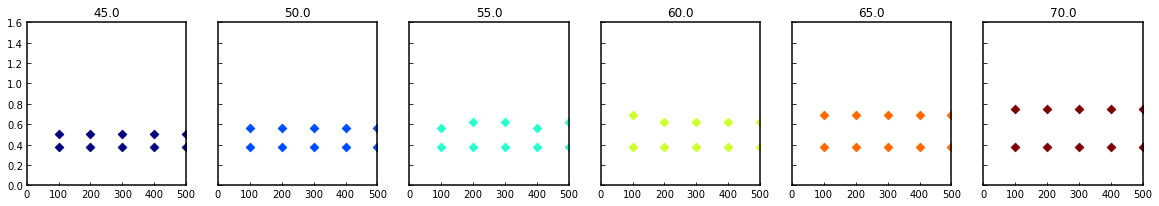

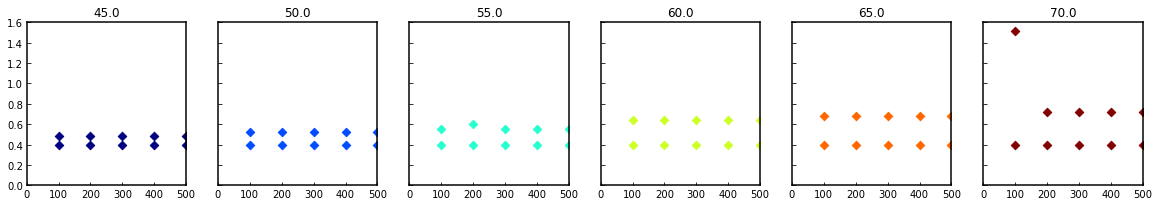

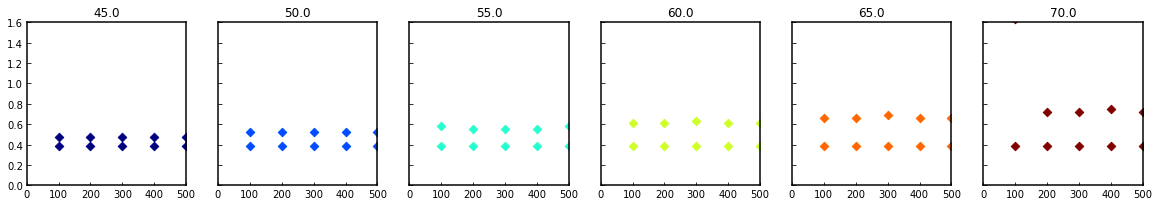

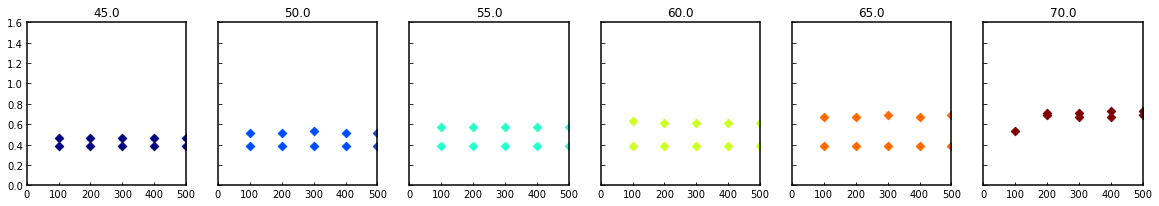

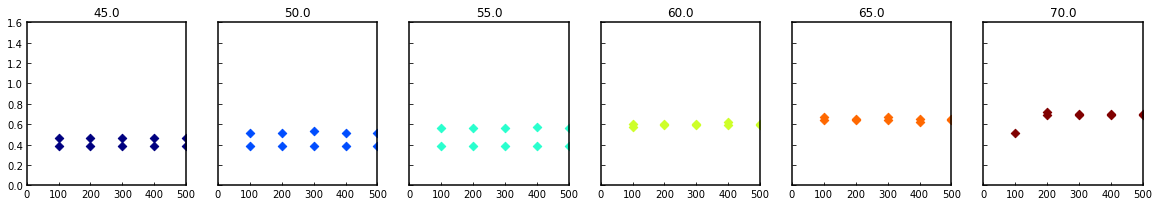

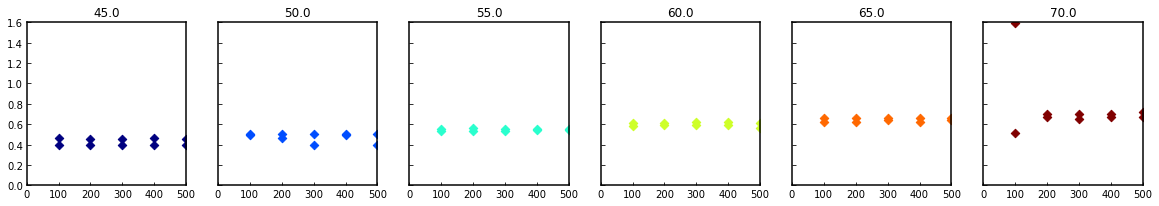

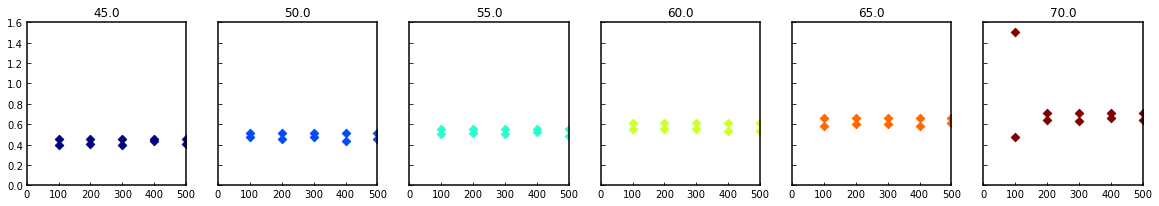

In [10]:
# Let's plot the first 4 densities side-by-side
uniquePhi = []
for i in phiList:
    if i not in uniquePhi:
        uniquePhi.append(i)
print(uniquePhi)

for j in range(1, len(headers) - 1, 2):
    # We want columns, phi= 45, 50, 55, 60, 65, 70
    fig, ax = plt.subplots(1, len(uniquePhi), figsize=(20, 3), sharey=True)
    for k in xrange(len(uniquePhi)):
        for i in xrange(len(all_data)):
            if params['phi'][i] == uniquePhi[k]:
                ax[k].scatter(params['peA'][i], all_data[i][headers[j]][0], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
                ax[k].scatter(params['peA'][i], all_data[i][headers[j+1]][0], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
        ax[k].set_xlim(0, 500.)
        ax[k].set_ylim(0, 1.6)
        ax[k].set_title(uniquePhi[k])
    plt.subplots_adjust(hspace=0.5)
    plt.show()


[45.0, 50.0, 55.0, 60.0, 65.0, 70.0]


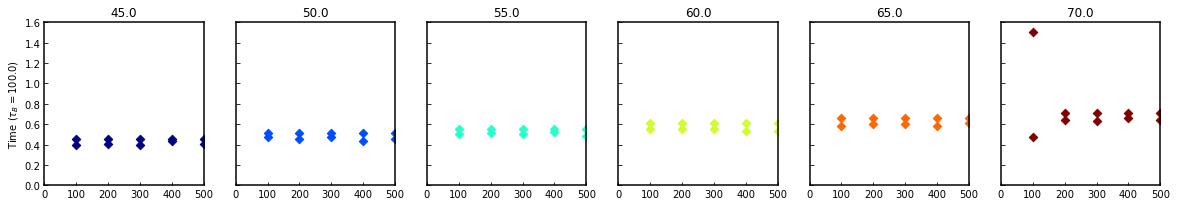

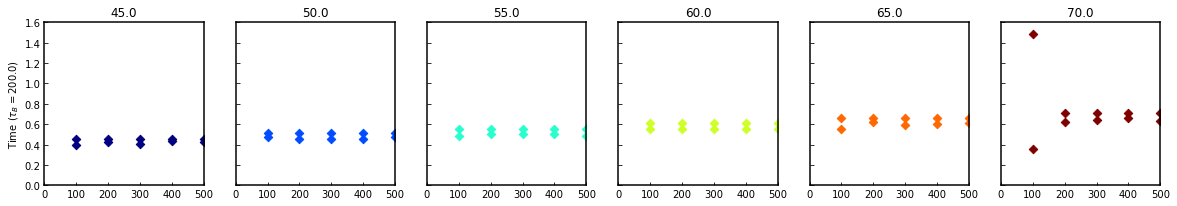

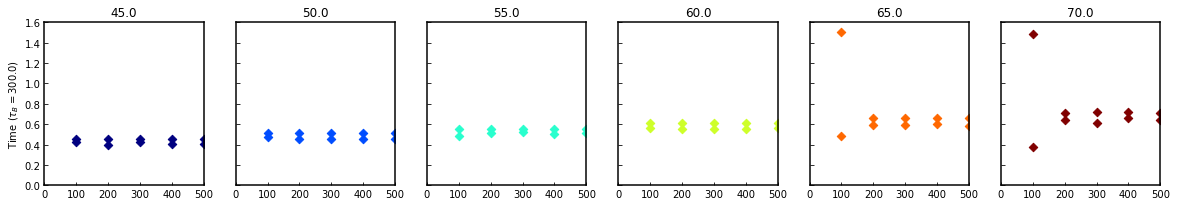

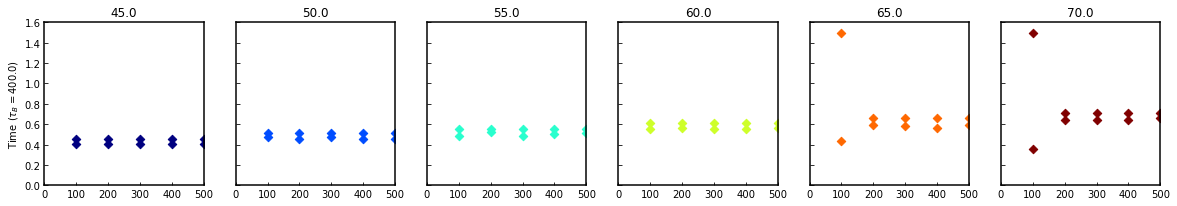

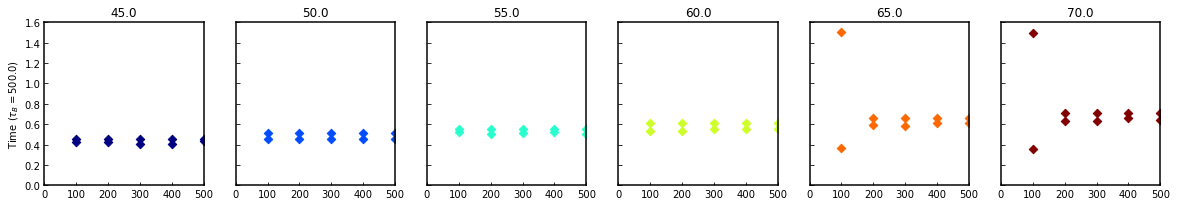

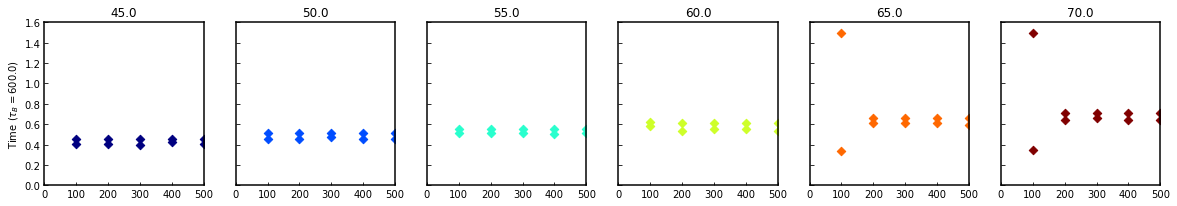

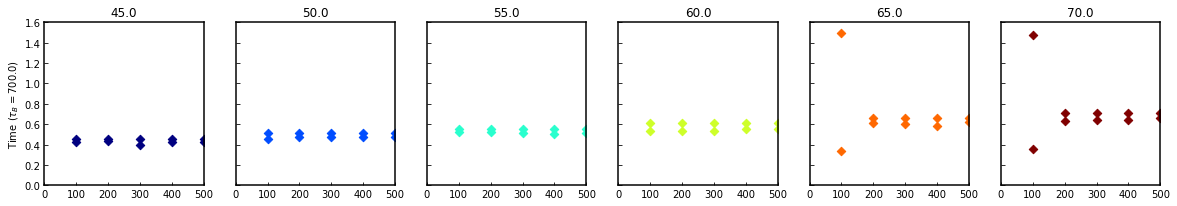

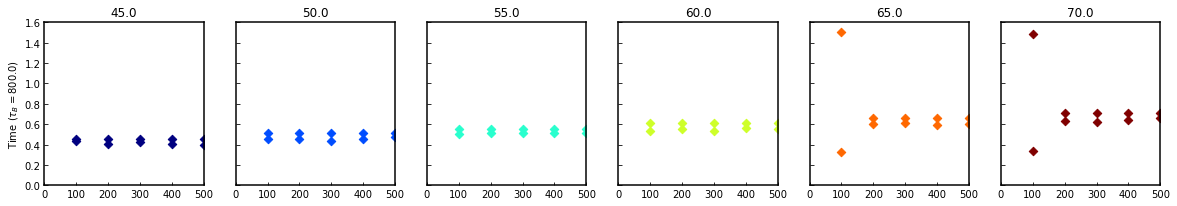

KeyError: 8

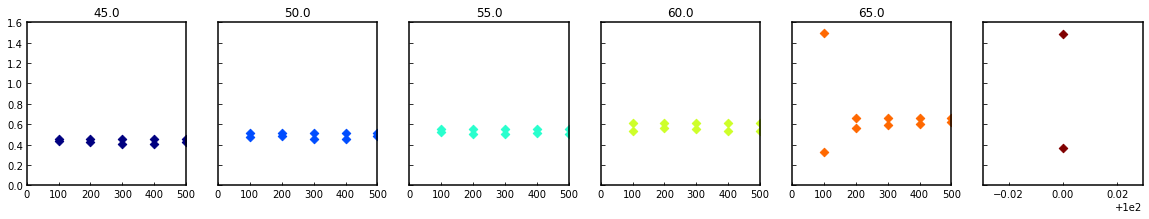

In [11]:
# Only take the r=5 search distance
uniquePhi = []
for i in phiList:
    if i not in uniquePhi:
        uniquePhi.append(i)
print(uniquePhi)


for j in range(len(headers)-2, len(headers) - 1, 2):
    # We want each time slice
    for m in xrange(len(all_data[0])):
        # We want columns, phi= 45, 50, 55, 60, 65, 70
        fig, ax = plt.subplots(1, len(uniquePhi), figsize=(20, 3), sharey=True)
        for k in xrange(len(uniquePhi)):
            for i in xrange(len(all_data)):
                if params['phi'][i] == uniquePhi[k]:
                    ax[k].scatter(params['peA'][i], all_data[i][headers[j]][m], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
                    ax[k].scatter(params['peA'][i], all_data[i][headers[j+1]][m], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
            ax[k].set_xlim(0, 500.)
            ax[k].set_ylim(0, 1.6)
            ax[k].set_title(uniquePhi[k])
        ax[0].set_ylabel(r'Time $(\tau_{B}=$' + str(all_data[0]['Timestep'][m]) + r'$)$')
        plt.subplots_adjust(hspace=0.5)
        plt.show()


In [ ]:
# Let's get an analytical expression for the local density of each phase
#  as a function of activity.
peFit = []
gas = 'Gas-r=5.0'
gasList = []
liq = 'Liq-r=5.0'
liqList = []
dens = 70.0
for i in xrange(len(all_data)):
    if params['phi'][i] == dens:
        peFit.append(params['peA'][i])
        gasList.append(all_data[i][gas].iloc[-1])
        liqList.append(all_data[i][liq].iloc[-1])

# We can cut out low Pe data (we don't need to artificially nucleate this)
peCut = 100.
# Make sure we've grabbed the appropriate data
plt.scatter(peFit, gasList, c='r')
plt.scatter(peFit, liqList, c='b')
plt.axvline(peCut, ls='--', lw=1.5, c='k', zorder=0)
# plt.xlim(40, 70)
plt.show()

# Let's trim the data so we are only fitting phase separated data
for i in range(len(peFit)-1, -1, -1):
    if peFit[i] < peCut:
        del peFit[i]
        del gasList[i]
        del liqList[i]

# Plot to observe this trimming of data
plt.scatter(peFit, gasList, c='r')
plt.scatter(peFit, liqList, c='b')
plt.axvline(peCut, ls='--', lw=1.5, c='k', zorder=0)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [ ]:
# Data has been trimmed looks like a power law

# Take the natural log of the data (fit to a line in logspace)
logPe = []
logGas = []
logLiq = []
for i in xrange(len(peFit)):
    logPe.append(np.log(peFit[i]))
    logGas.append(np.log(gasList[i]))
    logLiq.append(np.log(liqList[i]))
# Plot the log of the data    
plt.scatter(logPe, logGas)
plt.scatter(logPe, logLiq)
plt.show()

# Fit using linear regression
from scipy import stats
slopeG, interceptG, r_valueG, p_valueG, std_errG = stats.linregress(logPe,logGas)
slopeL, interceptL, r_valueL, p_valueL, std_errL = stats.linregress(logPe,logLiq)
rangeLog = np.arange(np.log(peCut), np.log(1000.))
def myLine(x, m, b):
    return (m*x) + b
# Plot the log of the data    
plt.scatter(logPe, logGas)
plt.scatter(logPe, logLiq)
plt.plot(rangeLog, myLine(rangeLog, slopeG, interceptG))
plt.plot(rangeLog, myLine(rangeLog, slopeL, interceptL))
plt.show()

# Plot it in real space now
rangeDat = np.arange(peCut, 1000.)
def myPow(x, m, b):
    return (x**m)*b
plt.scatter(peFit, gasList)
plt.scatter(peFit, liqList)
plt.plot(rangeDat, myPow(rangeDat, slopeG, np.exp(interceptG)))
plt.plot(rangeDat, myPow(rangeDat, slopeL, np.exp(interceptL)))
plt.show()

print("Expression for gas phase: m={}, b={}").format(slopeG, np.exp(interceptG))
print("Expression for liquid phase: m={}, b={}").format(slopeL, np.exp(interceptL))

In [ ]:
# Can we get the lattice spacing from the local area fraction

# We know that the lattice spacing of 1.0 has phi ~ 0.9
def phiProportion(phiIn):
    phiCP = np.pi / (2. * np.sqrt(3.))
    latCP = 1.
    return np.sqrt(phiCP / phiIn)

phis = np.arange(0.4, 1.5, 0.01)
plt.plot(phis, phiProportion(phis))
plt.scatter(liqList, phiProportion(liqList))
plt.xlabel(r'Local liquid density $(\phi_{l})$')
plt.ylabel(r'Lattice spacing $(a)$')
plt.xlim(1., 1.5)
plt.ylim(top=1.)
plt.show()

# print(phiProportion(1.))

In [ ]:
# Now let's look at the MCS data
mcs_headers = list(mcs[0])
print(mcs_headers)

for i in mcs_headers:
    for j in xrange(len(mcs)):
        if mcs[j][i].iloc[-1] < 100:  
            plt.plot(mcs[j]['Timestep'], mcs[j][i], c=plt.cm.jet((params['phi'][j]-45)/25.))
    plt.title(str(i))
#     plt.ylim(0, 100)
    plt.show()


In [ ]:
# Let's compute and look at the MCS
mcs_raw = []
mcs_thresh = []
mcs_1000 = []
for i in xrange(len(mcs)):
    mcs_raw.append(mcs[i]['all_parts'] / mcs[i]['N_clusts'])
    mcs_thresh.append(mcs[i]['thr_parts'] / mcs[i]['thr_clusts'])
    mcs_1000.append(mcs[i]['thr_p1000'] / mcs[i]['thr_c1000'])
    
for i in xrange(len(mcs)):
    plt.plot(mcs[i]['Timestep'], mcs_raw[i])
plt.xlim(1,)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

for i in xrange(len(mcs)):
    if mcs_thresh[i].iloc[-1] > 100:
        plt.plot(mcs[i]['Timestep'], mcs_thresh[i], c=plt.cm.jet((params['phi'][i]-45)/25.))
plt.xlim(10,)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

for i in xrange(len(mcs)):
#     if mcs_thresh[i].iloc[-1] > 100:
    plt.plot(mcs[i]['Timestep'], mcs_1000[i], c=plt.cm.jet((params['phi'][i]-45)/25.))
# plt.xlim(10,)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


In [ ]:
# Let's write a moving average for the MCS data
def movingAverage(inList, window=10):
    '''Read in the list to process and the window to average over'''
    side = window / 2
    outList = []
    for i in range(side, len(inList) - side):
        outList.append(np.mean(inList[i-side:i+side]))
    return outList

# Test the function
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
win = 20
smoothed = movingAverage(y, win)
import scipy.signal
smoothedSav = scipy.signal.savgol_filter(y, 51, 3)
plt.plot(x, y, c='r', lw=1.5)
plt.plot(x[win/2:len(x)-(win/2)], smoothed, c='b', lw=1.5)
plt.plot(x, smoothedSav, c='g', lw=1.5)
plt.show()

In [ ]:
# Test it with data
win = 10
side = win / 2
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i in xrange(len(mcs)):
    mcs_1000[i].fillna(0, inplace=True)
    ax[0].plot(mcs[i]['Timestep'], mcs_1000[i], c=plt.cm.jet((params['phi'][i]-45)/25.))
    smoothed = movingAverage(mcs_1000[i], win)
    ax[1].plot(mcs[i]['Timestep'][side:len(mcs[i]['Timestep'])-side], smoothed, c=plt.cm.jet((params['phi'][i]-45)/25.))
    smoothedSav = scipy.signal.savgol_filter(mcs_1000[i], 51, 3)
    ax[2].plot(mcs[i]['Timestep'], smoothedSav, c=plt.cm.jet((params['phi'][i]-45)/25.))
# plt.xlim(10,)
ax[0].set_title('Original')
ax[1].set_title('Moving Average')
ax[2].set_title('Savgol Filter')
ax[0].set_ylim(0,)
ax[1].set_ylim(0,)
ax[2].set_ylim(0,)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
# ax[2].set_xscale('log')
# ax[2].set_yscale('log')
plt.show()

# Test it with data
win = 10
side = win / 2
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i in xrange(len(mcs)):
    mcs_1000[i].fillna(0, inplace=True)
    ax[0].plot(mcs[i]['Timestep'], mcs_1000[i], c=plt.cm.jet(params['peA'][i]/500.))
    smoothed = movingAverage(mcs_1000[i], win)
    ax[1].plot(mcs[i]['Timestep'][side:len(mcs[i]['Timestep'])-side], smoothed, c=plt.cm.jet(params['peA'][i]/500.))
    smoothedSav = scipy.signal.savgol_filter(mcs_1000[i], 101, 3)
    ax[2].plot(mcs[i]['Timestep'], smoothedSav, c=plt.cm.jet(params['peA'][i]/500.))
# plt.xlim(10,)
ax[0].set_title('Original')
ax[1].set_title('Moving Average')
ax[2].set_title('Savgol Filter')
ax[0].set_ylim(0,)
ax[1].set_ylim(0,)
ax[2].set_ylim(0,)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
# ax[2].set_xscale('log')
# ax[2].set_yscale('log')
plt.show()